## Solutin by:
## Akshat Khare (AK7674)

# Problem Statement:
Robots are smart… by design. To fully understand and properly navigate a task, however, they need input about their environment.

In this competition, you’ll help robots recognize the floor surface they’re standing on using data collected from Inertial Measurement Units (IMU sensors).

We’ve collected IMU sensor data while driving a small mobile robot over different floor surfaces on the university premises. The task is to predict which one of the nine floor types (carpet, tiles, concrete) the robot is on using sensor data such as acceleration and velocity. Succeed and you'll help improve the navigation of robots without assistance across many different surfaces, so they won’t fall down on the job.

##### Importing the libraries which will be required 

In [127]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import os

In [128]:
import matplotlib.pyplot as plt
%matplotlib inline

# Importing the data:
#### Let's check what data files are available.

In [129]:
# read Kaggle datasets
X_train = pd.read_csv('X_train.csv')
y_train = pd.read_csv('y_train.csv')
# split X_train
samples = 20
time_series = 128
start_x = X_train.shape[0] - samples*time_series
X_train_new, X_test_new = X_train.iloc[:start_x], X_train.iloc[start_x:]
# split y_train
start_y = y_train.shape[0] - samples
y_train_new, y_test_new = y_train.iloc[:start_y], y_train.iloc[start_y:]

# Exploring data:

In [131]:
X_train_new.shape

(485120, 13)

In [132]:
X_test_new.shape

(2560, 13)

In [133]:
X_train_new.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


###### Measurements are taken in groups

In [134]:
X_test_new.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
485120,3790_0,3790,0,0.70992,0.68801,0.10876,0.10405,-0.87528,0.138350,0.037472,-2.4550,-0.89309,-20.6040
485121,3790_1,3790,1,0.70968,0.68818,0.10901,0.10429,-0.28090,0.046629,-0.225470,-9.9598,2.35790,-31.4030
485122,3790_2,3790,2,0.70967,0.68836,0.10872,0.10348,0.63630,0.297700,-0.063138,9.2911,-0.23731,-29.5370
485123,3790_3,3790,3,0.70975,0.68843,0.10819,0.10303,0.96157,0.106670,-0.127410,-12.8950,7.27000,1.6024
485124,3790_4,3790,4,0.70968,0.68858,0.10784,0.10289,0.28418,-0.101810,-0.140990,13.9830,8.90370,13.2140


##### Number of measurements in each series:

In [135]:
len(X_test_new.measurement_number.value_counts())

128

Each series has 128 measurements.

1 series = 128 measurements.



##### List of unique surfaces:

In [136]:
y_train_new['surface'].unique()

array(['fine_concrete', 'concrete', 'soft_tiles', 'tiled', 'soft_pvc',
       'hard_tiles_large_space', 'carpet', 'hard_tiles', 'wood'],
      dtype=object)

In [137]:
#Making sure there are no duplicates
X_train_df = X_train_new[['series_id']].drop_duplicates().reset_index(drop=True)

##### X_train and X_test datasets have the following entries:

series and measurements identifiers: row_id, series_id, measurement_number

measurement orientations: orientation_X, orientation_Y, orientation_Z, orientation_W;

angular velocities: angular_velocity_X, angular_velocity_Y, angular_velocity_Z;

linear accelerations: linear_acceleration_X, linear_acceleration_Y, linear_acceleration_Z.

###### y_train has the following columns:

series_id - this corresponds to the series in train data;
group_id;
surface - this is the surface type that need to be predicted.


# Plotting feature distribution:

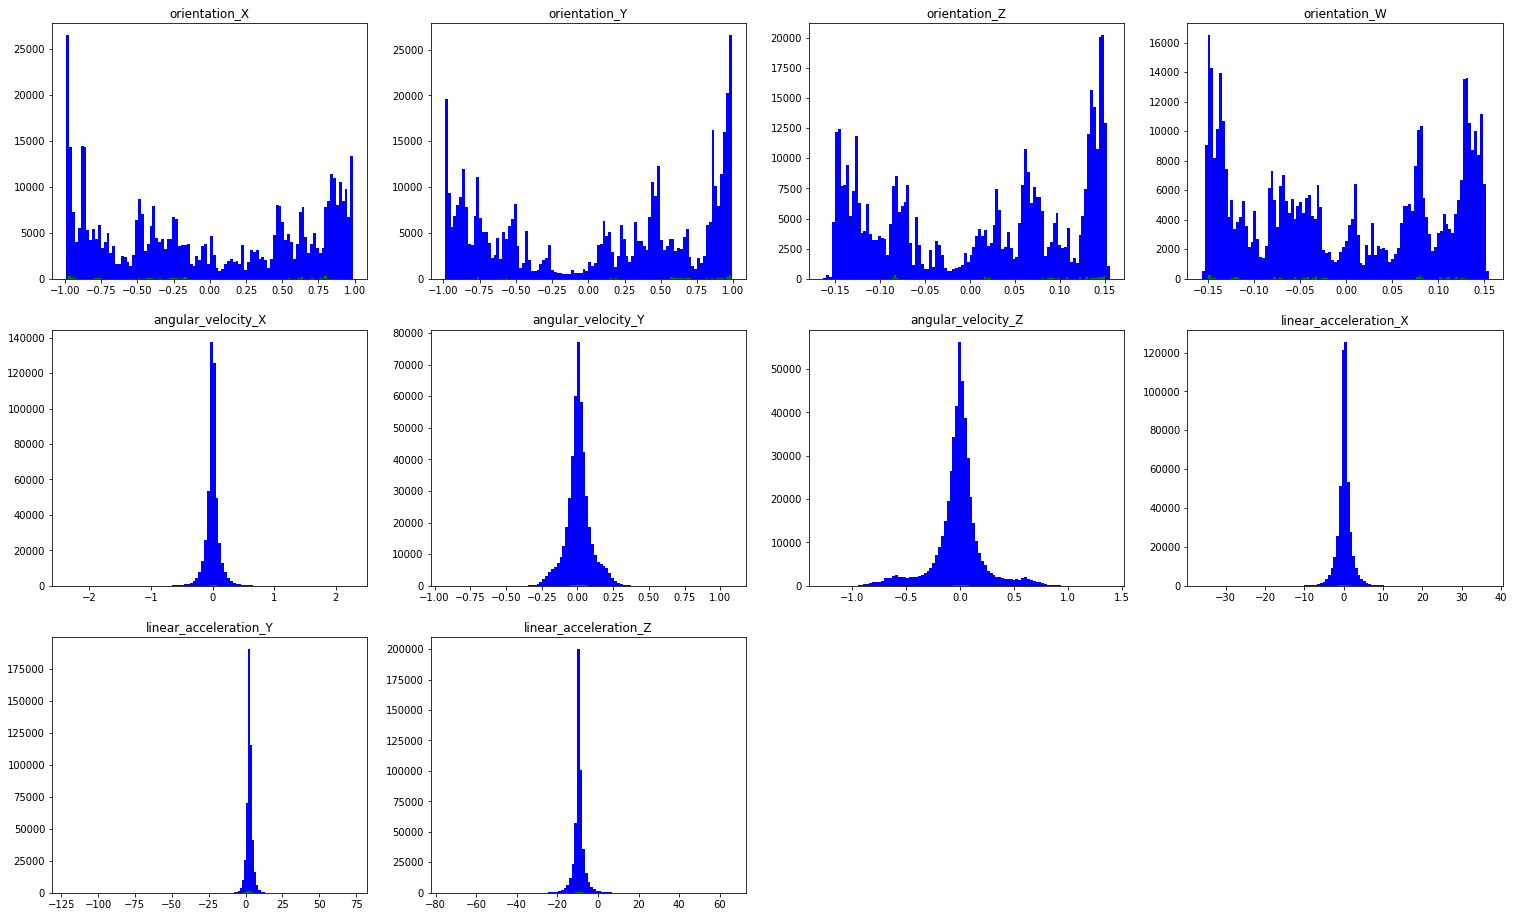

In [138]:
plt.figure(figsize=(26, 16))
for i, col in enumerate(X_train_new.columns[3:]):
    plt.subplot(3, 4, i + 1)
    plt.hist(X_train_new[col], color='blue', bins=100)
    plt.hist(X_test_new[col], color='green', bins=100)
    plt.title(col)

##### We can see that most of the features except orientations follow gaussian distribution.

### Lets see the count of each surface type in train data:

In [139]:
#Count for each surface type in train data:
target = y_train_new['surface'].value_counts().reset_index().rename(columns = {'index' : 'target'})
target

,target,surface
0,concrete,776
1,soft_pvc,730
2,wood,604
3,tiled,508
4,fine_concrete,360
5,hard_tiles_large_space,305
6,soft_tiles,297
7,carpet,189
8,hard_tiles,21


### Generating the correlation matrix:

In [140]:
confusion_matrix = X_train_new.corr()
confusion_matrix

,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
series_id,1.000000,0.000000,-0.024540,0.215712,0.225514,-0.040011,-0.002026,-0.017721,0.025322,-0.000967,-0.008871,-0.001839
measurement_number,0.000000,1.000000,-0.000320,0.000601,0.000606,-0.000319,-0.000366,0.000849,0.001225,-0.002039,-0.002630,-0.001080
orientation_X,-0.024540,-0.000320,1.000000,-0.185066,-0.133556,0.998373,0.001485,0.046707,-0.058154,-0.002532,-0.009699,-0.002093
orientation_Y,0.215712,0.000601,-0.185066,1.000000,0.997542,-0.225623,0.000483,0.020373,-0.024707,-0.003911,0.011814,0.002495
orientation_Z,0.225514,0.000606,-0.133556,0.997542,1.000000,-0.175842,0.000371,0.022378,-0.027143,-0.004212,0.009605,0.001886
orientation_W,-0.040011,-0.000319,0.998373,-0.225623,-0.175842,1.000000,0.001516,0.046319,-0.057746,-0.002896,-0.008936,-0.001904
angular_velocity_X,-0.002026,-0.000366,0.001485,0.000483,0.000371,0.001516,1.000000,-0.086389,-0.016457,-0.002984,-0.019245,-0.034618
angular_velocity_Y,-0.017721,0.000849,0.046707,0.020373,0.022378,0.046319,-0.086389,1.000000,-0.761955,-0.027572,0.015711,0.004667
angular_velocity_Z,0.025322,0.001225,-0.058154,-0.024707,-0.027143,-0.057746,-0.016457,-0.761955,1.000000,0.029014,0.000640,-0.001206
linear_acceleration_X,-0.000967,-0.002039,-0.002532,-0.003911,-0.004212,-0.002896,-0.002984,-0.027572,0.029014,1.000000,0.057272,0.018587


Very strong correlation (1.0) is between orientation_X and orientation_W and between orientation_Z and orientation_Y.

There is a strong inverse correlation (-0.8) between angular_velocity_Z and angular_velocity_Y.

Also, there is a medium positive correlation (0.4) between linear_acceleration_Y and linear_acceleration_Z.

##### Orientation - quaternion coordinates

You could notice that there are 4 coordinates: X, Y, Z, W.

Usually we have X, Y, Z - Euler Angles. But Euler Angles are limited by a phenomenon called "gimbal lock," which prevents them from measuring orientation when the pitch angle approaches +/- 90 degrees. Quaternions provide an alternative measurement technique that does not suffer from gimbal lock. Quaternions are less intuitive than Euler Angles and the math can be a little more complicated.

Source - https://www.kaggle.com/jesucristo/1-smart-robots-most-complete-notebook

In [141]:
# https://stackoverflow.com/questions/53033620/how-to-convert-euler-angles-to-quaternions-and-get-the-same-euler-angles-back-fr?rq=1
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [142]:
def euler_angle(data):
    x, y, z, w = data['orientation_X'].tolist(), data['orientation_Y'].tolist(), data['orientation_Z'].tolist(), data['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    data['euler_x'] = nx
    data['euler_y'] = ny
    data['euler_z'] = nz
    
    return data

In [143]:
X_train_new = euler_angle(X_train_new)
X_test_new = euler_angle(X_test_new)

Inside euler angle


/Users/akshatkhare/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
/Users/akshatkhare/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if sys.path[0] == '':


Inside euler angle


/Users/akshatkhare/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


### Please ignore the warning above, it does not affect the outcomes. 

# Feature Engineering:
#### Since we have series, it is better to create aggregate features

In [144]:
def perform_feature_engineering(df):
    df_out = pd.DataFrame()
    
    def mean_change_of_abs_change(x):
        return np.mean(np.diff(np.abs(np.diff(x))))

    def mean_abs_change(x):
        return np.mean(np.abs(np.diff(x)))
    
    for col in df.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        df_out[col + '_mean'] = df.groupby(['series_id'])[col].mean()
        df_out[col + '_min'] = df.groupby(['series_id'])[col].min()
        df_out[col + '_max'] = df.groupby(['series_id'])[col].max()
        df_out[col + '_std'] = df.groupby(['series_id'])[col].std()
        df_out[col + '_mad'] = df.groupby(['series_id'])[col].mad()
        df_out[col + '_med'] = df.groupby(['series_id'])[col].median()
        df_out[col + '_skew'] = df.groupby(['series_id'])[col].skew()
        df_out[col + '_range'] = df_out[col + '_max'] - df_out[col + '_min']
        df_out[col + '_max_to_min'] = df_out[col + '_max'] / df_out[col + '_min']
        df_out[col + '_mean_abs_change'] = df.groupby('series_id')[col].apply(mean_abs_change)
        df_out[col + '_mean_change_of_abs_change'] = df.groupby('series_id')[col].apply(mean_change_of_abs_change)
        df_out[col + '_abs_max'] = df.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        df_out[col + '_abs_min'] = df.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))
        df_out[col + '_abs_mean'] = df.groupby('series_id')[col].apply(lambda x: np.mean(np.abs(x)))
        df_out[col + '_abs_std'] = df.groupby('series_id')[col].apply(lambda x: np.std(np.abs(x)))
        df_out[col + '_abs_avg'] = (df_out[col + '_abs_min'] + df_out[col + '_abs_max'])/2
        df_out[col + '_abs_range'] = df_out[col + '_abs_max'] - df_out[col + '_abs_min']

    return df_out

In [145]:
X_train_new = perform_feature_engineering(X_train_new[X_train_new.columns.values])


###### Seeing the results after performing feature engineering:

In [146]:
X_train_new.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_mad,orientation_X_med,orientation_X_skew,orientation_X_range,orientation_X_max_to_min,orientation_X_mean_abs_change,...,euler_z_range,euler_z_max_to_min,euler_z_mean_abs_change,euler_z_mean_change_of_abs_change,euler_z_abs_max,euler_z_abs_min,euler_z_abs_mean,euler_z_abs_std,euler_z_abs_avg,euler_z_abs_range
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75953,-0.75822,0.000363,0.000311,-0.758530,-0.659082,0.00131,0.998275,0.000015,...,0.004169,1.002992,0.000051,1.602451e-07,1.397402,1.393233,1.396035,0.001217,1.395317,0.004169
1,-0.958606,-0.95896,-0.95837,0.000151,0.000126,-0.958595,-0.397289,0.00059,0.999385,0.000023,...,0.004477,0.990949,0.000147,1.303804e-07,0.494641,0.490164,0.492731,0.001127,0.492402,0.004477
2,-0.512057,-0.51434,-0.50944,0.001377,0.001144,-0.512035,0.151971,0.00490,0.990473,0.000041,...,0.011604,1.005661,0.000097,-8.169853e-07,2.061288,2.049684,2.055021,0.003207,2.055486,0.011604
3,-0.939169,-0.93968,-0.93884,0.000227,0.000197,-0.939170,-0.096106,0.00084,0.999106,0.000026,...,0.004046,0.993661,0.000071,9.790398e-08,0.638340,0.634294,0.635656,0.000928,0.636317,0.004046
4,-0.891301,-0.89689,-0.88673,0.002955,0.002562,-0.890940,-0.226700,0.01016,0.988672,0.000080,...,0.047056,0.948575,0.000371,4.805791e-07,0.915040,0.867983,0.894147,0.013782,0.891511,0.047056


###### Performing feature engineering for test data

In [147]:
X_test_new = perform_feature_engineering(X_test_new[X_test_new.columns.values])

###### Seeing the results after performing feature engineering:

In [148]:
X_test_new.head()

,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_mad,orientation_X_med,orientation_X_skew,orientation_X_range,orientation_X_max_to_min,orientation_X_mean_abs_change,...,euler_z_range,euler_z_max_to_min,euler_z_mean_abs_change,euler_z_mean_change_of_abs_change,euler_z_abs_max,euler_z_abs_min,euler_z_abs_mean,euler_z_abs_std,euler_z_abs_avg,euler_z_abs_range
series_id,,,,,,,,,,,,,,,,,,,,,
3790,0.710416,0.70935,0.71142,0.000525,0.000434,0.710435,0.151091,0.00207,1.002918,0.000097,...,0.005808,1.003779,0.000234,-3.147733e-06,1.542904,1.537096,1.540088,0.001531,1.540000,0.005808
3791,0.804211,0.80275,0.80611,0.000996,0.000840,0.803990,0.515964,0.00336,1.004186,0.000105,...,0.012543,0.989929,0.000312,6.957789e-06,1.245462,1.232919,1.239159,0.003548,1.239190,0.012543
3792,0.640428,0.63847,0.64262,0.001154,0.000992,0.640285,0.304444,0.00415,1.006500,0.000033,...,0.011175,0.993588,0.000090,3.415176e-07,1.742940,1.731765,1.737856,0.003055,1.737352,0.011175
3793,-0.977197,-0.97818,-0.97569,0.000703,0.000620,-0.977295,0.376525,0.00249,0.997454,0.000023,...,0.030335,0.905982,0.000239,-1.407090e-06,0.322652,0.292317,0.305397,0.009224,0.307485,0.030335
3794,0.765214,0.75541,0.77466,0.005612,0.004859,0.765540,-0.046538,0.01925,1.025483,0.000152,...,0.061836,1.046024,0.000487,1.628840e-06,1.405407,1.343571,1.373901,0.017901,1.374489,0.061836


In [149]:
scaler = StandardScaler()
X_train_scaled = pd.DataFrame(scaler.fit_transform(X_train_new))
X_test_scaled = pd.DataFrame(scaler.transform(X_test_new))

##### Converting the surface names to integer values to pass it in the random forest classifier

In [150]:
#Giving each output surface an integer value
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y_train_new['surface'] = le.fit_transform(y_train_new['surface'])


/Users/akshatkhare/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


### Please ignore the warning above, it does not affect the results

# Model interpretation: 

##### The algorithm I will be using is random forest classifier:

Random forest is the most simple and widely used algorithm. Used for both classification and regression. It is an ensemble of randomized decision trees. Each decision tree gives a vote for the prediction of target variable. Random forest choses the prediction that gets the most vote.

Random Forest is a ensemble bagging algorithm to achieve low prediction error. It reduces the variance of the individual decision trees by randomly selecting trees and then either average them or picking the class that gets the most vote.



In [151]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold

In [152]:
n_fold = 20
folds = StratifiedKFold(n_splits=n_fold, shuffle=True, random_state=11)

In [153]:
predicted = np.zeros((X_test_scaled.shape[0], 9))
measured = np.zeros((X_train_scaled.shape[0]))
score = 0

In [154]:
for fold_, (trn_idx, val_idx) in enumerate(folds.split(X_train_scaled, y_train_new['surface'])):
    model =  RandomForestClassifier(n_estimators = 500, n_jobs = -1)
    model.fit(X_train_scaled.iloc[trn_idx], y_train_new['surface'][trn_idx])
    measured[val_idx] = model.predict(X_train_scaled.iloc[val_idx])
    predicted += model.predict_proba(X_test_scaled) / folds.n_splits
    score += model.score(X_train_scaled.iloc[val_idx], y_train_new['surface'][val_idx])
    print('Fold: {} score: {}'.format(fold_,model.score(X_train_scaled.iloc[val_idx], y_train_new['surface'][val_idx])))
print('Avg Accuracy', score / folds.n_splits)


Fold: 0 score: 0.9072164948453608
Fold: 1 score: 0.9222797927461139
Fold: 2 score: 0.9481865284974094
Fold: 3 score: 0.9119170984455959
Fold: 4 score: 0.953125
Fold: 5 score: 0.9109947643979057
Fold: 6 score: 0.9057591623036649
Fold: 7 score: 0.9162303664921466
Fold: 8 score: 0.9052631578947369
Fold: 9 score: 0.9523809523809523
Fold: 10 score: 0.9308510638297872
Fold: 11 score: 0.9148936170212766
Fold: 12 score: 0.925531914893617
Fold: 13 score: 0.9202127659574468
Fold: 14 score: 0.8882978723404256
Fold: 15 score: 0.9148936170212766
Fold: 16 score: 0.8823529411764706
Fold: 17 score: 0.9193548387096774
Fold: 18 score: 0.9086021505376344
Fold: 19 score: 0.9193548387096774
Avg Accuracy 0.9178849469100585


##### Converting the surface names back to original values from integer values for better readability

In [156]:

results= le.inverse_transform(predicted.argmax(axis=1))


#### Calculating the accuracy:

In [193]:
count = 0
for i in range(0, len(y_test_new)):
    if results[i] == y_test_new['surface'][y_test_new.first_valid_index()+i]:
        count +=1


In [196]:
print("Accuracy of the algorithm is:", float(count/len(y_test_new))* 100 , "%" )

Accuracy of the algorithm is: 90.0 %


References - 
https://www.kaggle.com/jesucristo/1-smart-robots-most-complete-notebook
https://www.kaggle.com/artgor/where-do-the-robots-drive
https://www.kaggle.com/prashantkikani/help-humanity-by-helping-robots
https://www.kaggle.com/jesucristo/1-smart-robots-complete-compilation